In [1]:
from fastai2.vision.all import *
from torch.optim.lr_scheduler import LambdaLR


## Loading the data

In [2]:
path = untar_data(URLs.IMAGENETTE)
files = get_image_files(path)

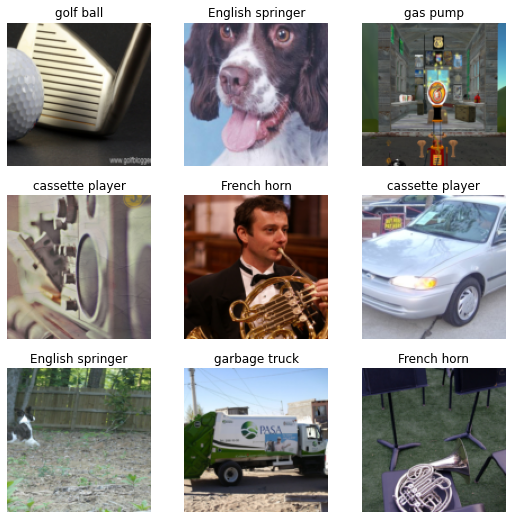

In [3]:
lbl_dict = dict(
    n01440764='tench',
    n02102040='English springer',
    n02979186='cassette player',
    n03000684='chain saw',
    n03028079='church',
    n03394916='French horn',
    n03417042='garbage truck',
    n03425413='gas pump',
    n03445777='golf ball',
    n03888257='parachute'
)

def label_func(fname):

    return lbl_dict[parent_label(fname)]

dblock = DataBlock(
    blocks    = (ImageBlock, CategoryBlock),
   get_items = get_image_files,
   get_y     = label_func,
   splitter  = GrandparentSplitter(),
   item_tfms = RandomResizedCrop(128, min_scale=0.35), 
   batch_tfms=[Normalize.from_stats(*imagenet_stats)]
)
dls = dblock.dataloaders(path, bs=128)
dls.show_batch()

## Model

In [4]:
def loss_func(outputs, targets):
    return CrossEntropyLossFlat()(outputs, targets)

def create_model():
    encoder = create_body(resnet34, cut=-2, pretrained=True)
    head = create_head(1024, len(lbl_dict), ps=0.5)
    model = nn.Sequential(encoder, head).cuda()
    
    return model

def model_param_splitter(model):
    return [params(model[0]), params(model[1])]

def freeze_to(model, n):
    #TODO don't freeze batch norm
    assert n >= 0
    params_groups = model_param_splitter(model)
    assert n < len(params_groups), f"len(params_groups) = {len(params_groups)} but n = {n}"
    
    for group in params_groups[:n]:
        for o in group:
            o.requires_grad = False
    
    for group in params_groups[n:]:
        for o in group:
            o.requires_grad = True

## LR finder

In [5]:
#export
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
import numpy as np
from torch.optim.lr_scheduler import LambdaLR

class LRFinderSchedular(LambdaLR):
    def __init__(self,
        optimizer: Optimizer,
        start_lr: float = 1e-7,
        end_lr: float = 10,
        num_it: int = 100,
    ) -> None:
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_it = num_it
        self.scheduled_lrs = np.logspace(np.log10(start_lr), np.log10(end_lr), num_it)

        for param_group in optimizer.param_groups:
            param_group["lr"] = 1
        
        super(LRFinderSchedular, self).__init__(optimizer, self._lr_lambda_, last_epoch=-1)

    def _lr_lambda_(self, epoch: int):
        return self.scheduled_lrs[epoch]
    
SuggestedLRs = collections.namedtuple('SuggestedLRs', ['lr_min', 'lr_steep'])    
    
class LRFinder:
    
    def __init__(
        self,        
        start_lr: float = 1e-7,
        end_lr: float = 10,
        num_it: int = 100,
        beta: float = 0.9        
    ):
        assert 0 <= beta < 1
        self.start_lr = start_lr
        self.end_lr = end_lr
        self.num_it = num_it
        self.beta = beta
        
    def _moving_average(self, array):
        res = [array[0]]
        for v in array[1:]:
            res.append(self.beta * res[-1] + (1 - self.beta) * v)
            
        return np.array(res)
        
    def find(
        self,
        model,
        optimizer,
        loss_func,
        data_loader,
        plot = True
    ):
        tmp_folder = Path("./.tmp")
        weight_file = tmp_folder / "weights"
        
        tmp_folder.mkdir(exist_ok=True)
        torch.save(model.state_dict(), weight_file)
        
        lr_scheduler = LRFinderSchedular(optimizer, self.start_lr, self.end_lr, self.num_it)
        
        
        n_epoch = self.num_it // len(data_loader) + 1
        is_done = False
        
        lrs = []
        loss_measurements = []
        i = 0
        
        for _ in range(n_epoch):
            for inputs, targets in tqdm(data_loader):
                prediction = model(inputs)
                losses = loss_func(prediction, targets)
                
                if torch.isnan(losses):
                    break
                    
                lrs.append(lr_scheduler.get_last_lr())
                loss_measurements.append(float(losses))
                
                optimizer.zero_grad()
                losses.backward()
                optimizer.step()

                i += 1
                if i >= self.num_it or float(losses) > 3 * loss_measurements[0]:
                    break
                    
                lr_scheduler.step()
                
            else:
                continue
            break
            
        model.load_state_dict(torch.load(weight_file))
        weight_file.unlink()
        
        lrs = np.array(lrs).squeeze()
        loss_measurements = np.array(loss_measurements).squeeze()
        smoothed_loss_measurements = self._moving_average(loss_measurements)
        gradients = self._gradients(lrs, smoothed_loss_measurements)
        
        if plot:
            self._plot(lrs, smoothed_loss_measurements)
        
        lr_min = lrs[np.argmin(smoothed_loss_measurements)] * (1 - self.beta)
        lr_steep = lrs[np.argmin(gradients)]
        
        return SuggestedLRs(lr_min, lr_steep)

        
    def _plot(self, lrs, smoothed_loss_measurements):
        plt.plot(lrs, smoothed_loss_measurements)
        plt.xlabel("lr")
        plt.ylabel("losses")
        plt.xscale("log")
        plt.grid()
        plt.show()
        
    def _gradients(self, lrs, smoothed_loss_measurements):
        return (smoothed_loss_measurements[1:]-smoothed_loss_measurements[:-1]) / (np.log10(lrs[1:]) - np.log10(lrs[:-1]))
        
    

In [6]:
!python notebook2script.py lrFinder.ipynb

Converted lrFinder.ipynb to exp/nb_lrFinder.py


## Results

In [7]:
lr_finder = LRFinder()
model = create_model().cuda()

### Head only

 16%|█▋        | 12/73 [00:03<00:15,  3.91it/s]


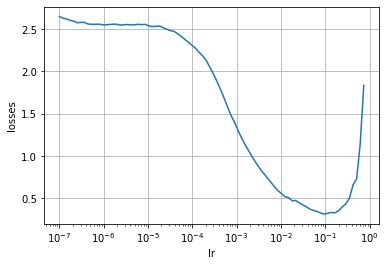

SuggestedLRs(lr_min=0.009545484566618344, lr_steep=0.000521400828799969)

In [8]:
freeze_to(model, 1)

trainable_paramters = trainable_params(model)
optimizer = torch.optim.Adam(trainable_paramters)
lr_finder.find(model, optimizer, loss_func, dls.train)

### Backbone + Head

 10%|▉         | 7/73 [00:03<00:32,  2.04it/s]


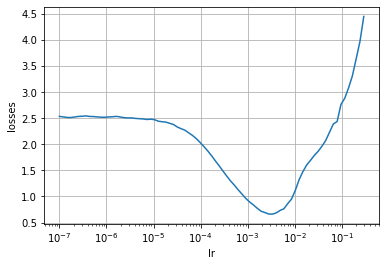

SuggestedLRs(lr_min=0.00033516026509388465, lr_steep=0.0002477076355991711)

In [9]:
freeze_to(model, 0)

trainable_paramters = trainable_params(model)
optimizer = torch.optim.Adam(trainable_paramters)
lr_finder.find(model, optimizer, loss_func, dls.train)